# Regime-Aware Volatility

We established:
- Log returns are approximately stationary
- Volatility clustering is present
- Market behavior is not structurally constant over long horizons

This notebook focus is on statistical model for volatility forecasting, and regime shift estimation. 

## Setup & Import

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# model

from arch import arch_model

In [3]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from dataclasses import dataclass, asdict
from typing import Optional, Dict, Any

In [4]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Preparation

In [6]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
print("are dates sorted?:", df.index.is_monotonic_increasing)

are dates sorted?: True


In [7]:
df_train, df_test = train_test_split(df, shuffle=False, train_size=0.8)

In [8]:
# is variance modeling actually needed?
std_resid = StandardScaler().fit_transform(df[['LogReturn']].dropna())
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=12)
print("ARCH test on std resid p-value:", lm_pvalue)

ARCH test on std resid p-value: 2.2323459794439725e-112


ARCH LM null hypothesis assume all coffiecient including the constant is 0. 
p <<< 0.05 conforms that volatility clusters and varying conditional volatility.

## Baseline Model

In [9]:
# target window
TARGET = 1 # in days

# scaling for numeric stability 
r_pct = df['LogReturn'].dropna() * 100 

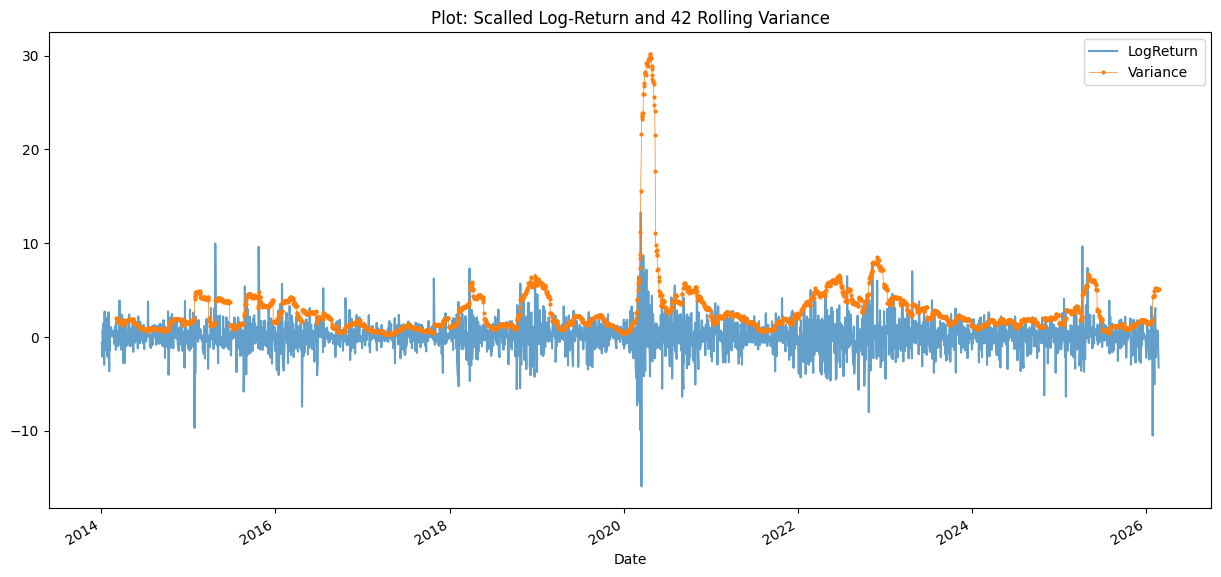

In [ ]:
roll = 42
plt.figure(figsize=(15, 7))
(r_pct).plot(legend=True, alpha=0.7)
#(r_pct ** 2).plot(legend=True, label='variance')
(r_pct).rolling(roll).var().plot(legend=True, label='Variance', 
                               marker='o', markersize=2, linewidth=0.5)
plt.title(f"Plot: Scalled Log-Return and {roll} Rolling Variance")
plt.show()

GARCH might perform better.

In [11]:
np.round(r_pct.mean(), 4)

np.float64(0.0828)

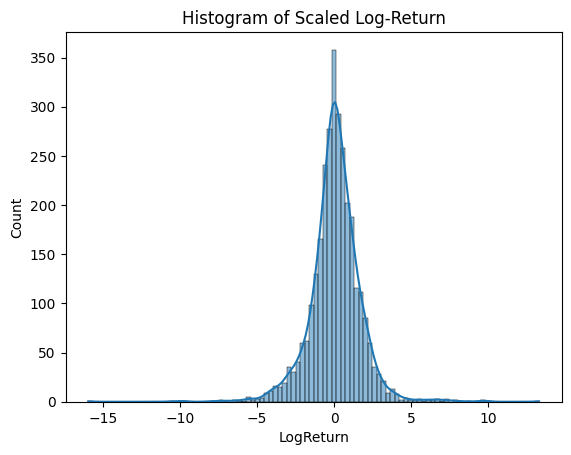

In [12]:
sns.histplot(r_pct, bins=100, kde=True)
plt.title('Histogram of Scaled Log-Return')
plt.show()

R^2 metrics are meaningless in volatility modeling, they refer to mean equation which is 0 

In [13]:
models = pd.DataFrame(columns=['model', 'aic', 'bic', 'lik'])

params = [1, 2, 5, 10, 15]
progress = 0
# p and q - based on squared return ACF plot
for p, q in itertools.product(params, repeat=2):
    progress += 1
    arch_fit = arch_model(r_pct.values, mean="Zero", vol='ARCH', p=p, dist='normal').fit(disp='off')
    garch_fit = arch_model(r_pct.values, mean='Zero', vol='GARCH', p=p, q=q, dist='normal').fit(disp='off')
    
    models.loc[f'arch{p}'] = arch_fit, arch_fit.aic, arch_fit.bic, arch_fit.loglikelihood
    models.loc[f'g{q}arch{p}'] = garch_fit, garch_fit.aic, garch_fit.bic, garch_fit.loglikelihood
    
    print(f"\rProgress: {progress} out of {len(params)**2} done", end='')

Progress: 25 out of 25 done

In [14]:
print(f"best model wrt AIC: {models['aic'].idxmin()}, with score: {models['aic'].min()}")
print(f"best model wrt BIC: {models['bic'].idxmin()}, with score: {models['bic'].min()}")

best model wrt AIC: arch15, with score: 11210.092779426244
best model wrt BIC: g1arch1, with score: 11231.289224692084


In [15]:
models.sort_values(by='aic').head(5)

,model,aic,bic,lik
arch15,Zero Mean - ARCH Model...,11210.092779,11306.469618,-5589.046390
g1arch15,Zero Mean - GARCH Model...,11212.092780,11314.493171,-5589.046390
g1arch1,Zero Mean - GARCH Model...,11213.218568,11231.289225,-5603.609284
g2arch15,Zero Mean - GARCH Model...,11214.092780,11322.516723,-5589.046390
g10arch5,Zero Mean - GARCH Model...,11214.679072,11311.055911,-5591.339536


In [16]:
models.sort_values(by='bic').head(5)

,model,aic,bic,lik
g1arch1,Zero Mean - GARCH Model...,11213.218568,11231.289225,-5603.609284
g1arch2,Zero Mean - GARCH Model...,11214.980284,11239.074494,-5603.490142
g2arch1,Zero Mean - GARCH Model...,11215.218568,11239.312777,-5603.609284
g2arch2,Zero Mean - GARCH Model...,11216.908747,11247.026509,-5603.454374
g1arch5,Zero Mean - GARCH Model...,11219.568682,11261.733549,-5602.784341


The ACF plot suggested long memory, however GARCH(1,1) == short lag giving a very contrained shape fit. Loglikehood of returns given the model-fit suggest that GARCH(1,1) is even worse than others.

ARCH(15) == high lag with highest AIC probably be an overfitting the training data.

The log likehood of arch(15) and GARCH(15, 1) is same, suggesting lagged variance parameter isn't doing anything. even the GARCH(1,1) and ARCH(15)

#### New insight: GARCH(1, 1) = ARCH(inf.) in geometric decaying weights(coeff). => the variance feedback recursively carries shocks into all future periods.

In [17]:
# rolling forecasting
rolling_pred = []
duration = 252*2 # 2 years

for day in range(0, duration):
    train = r_pct[:-(duration-day)]
    arch_fit = arch_model(train, p=15).fit(disp='off')
    
    pred_stats = arch_fit.forecast(horizon=TARGET)
    pred_var = pred_stats.variance.iloc[-1, 0]
    pred_vol = np.sqrt(pred_var + 0) # 0 mean
    rolling_pred.append(pred_vol)
    print(f'\r done {day}/{duration}', end='')
    
rolling_pred = pd.Series(rolling_pred, index=r_pct.index[-duration:])

 done 503/504

In [18]:
# rolling forecasting
rolling_pred_g = []
duration = 252*2 # 2 years

for day in range(duration):
    train = r_pct[:-(duration-day)]
    arch_fit = arch_model(train, p=1, q=1).fit(disp='off')
    
    pred_stats = arch_fit.forecast(horizon=TARGET)
    pred_var = pred_stats.variance.iloc[-1, 0]
    pred_vol = np.sqrt(pred_var + 0) # 0 mean
    rolling_pred_g.append(pred_vol)
    print(f'\r done {day}/{duration}', end='')
    
rolling_pred_g = pd.Series(rolling_pred_g, index=r_pct.index[-duration:])

 done 503/504

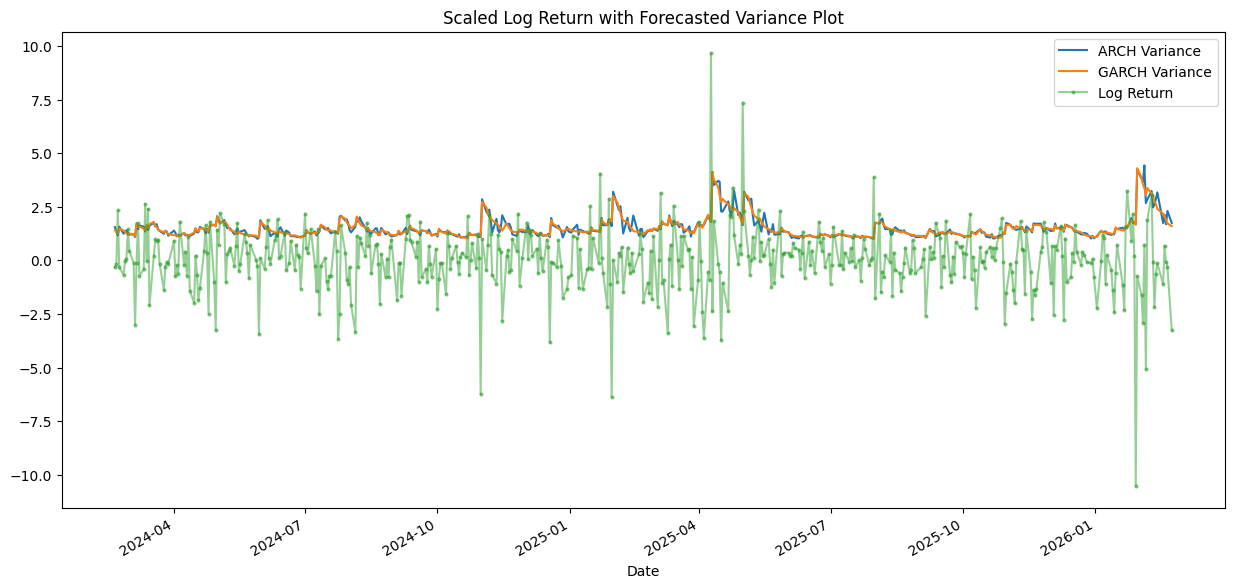

In [19]:
plt.figure(figsize=(15, 7))
rolling_pred.plot(label="ARCH Variance")
rolling_pred_g.plot(label="GARCH Variance")
r_pct[-duration:].plot(alpha=0.5, label="Log Return", marker='o', markersize=2)
plt.title("Scaled Log Return with Forecasted Variance Plot")
plt.legend()
plt.show()

One-off shock: ~ late Jan / early Feb 2026

Major burst: ~ March–April 2025

Minor burst: ~ Nov–Dec 2024

(G)ARCH is not capable of capturing single-day extreme spikes.

In [20]:
print(f"Excess Kurtosis: {r_pct.kurtosis()}")

Excess Kurtosis: 8.364221352541321


The log-return have high kurtosis, suggesting fat tailed distributed. 

The fat tails is likely goverened by COVID-19 (e.g., large and rare event) influence parameter estimates and volatility dynamics.

Next steps:

* Try GARCH with Student-t errors - can capture extreme spikes.

* Test asymmetric models (GJR-GARCH / EGARCH).

* Compare out-of-sample, pre-covid, post-covid sample.

* Test  shift regimes as volatility processes often breaks

For now, focus on modeling returns; later extend to risk measures (VaR, Expected Shortfall) and forecasting performance evaluation.

In [21]:
# rolling volatility forecast using GARCH with student t-error
arch_model(train, p=1, q=1, vol='GARCH', dist='studentst')

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Standardized Student's t distribution), id: 0x2f2d3b49a30

In [22]:
# flexible 
@dataclass
class ModelSpec:
    # default model params
    p: int = 1
    vol: str = 'ARCH'
    # additional user defined param
    def to_kwargs(self):
        return asdict(self)

def rolling_vol(returns=r_pct, duration=duration, **kwargs):
    spec = ModelSpec()
    model_params = {**spec.to_kwargs(), **kwargs}
    pred_vol_list = []
    
    for day in range(duration):
        train = returns[:-(duration-day)]
        model_fit = arch_model(train, **model_params).fit(disp='off')
        pred_stats = model_fit.forecast(horizon=TARGET)

        pred_var = pred_stats.variance.iloc[-1, 0]
        pred_vol = np.sqrt(pred_var)
        pred_vol_list.append(pred_vol)
        print(f"\rDone {day+1}/{duration}", end="")
        
    pred_vol_list = pd.Series(pred_vol_list, index=returns.index[-duration:])
    return pred_vol_list

In [23]:
rolling_pred_garch_t = rolling_vol(duration=252*2, vol='GARCH', p=1, q=1, dist='studentst')

Done 504/504

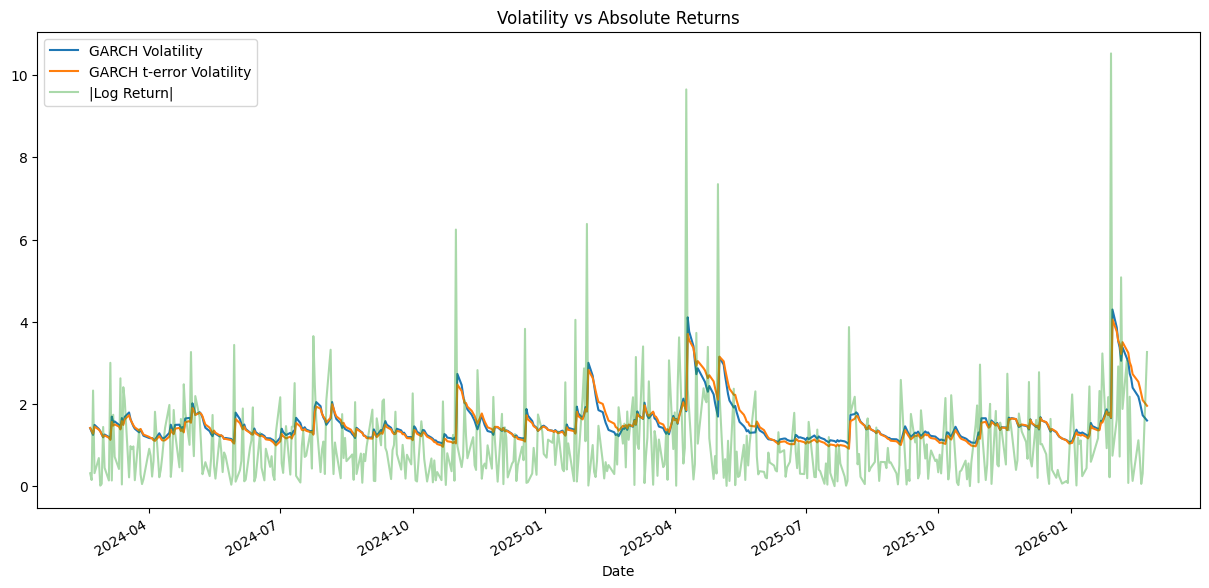

In [24]:
plt.figure(figsize=(15,7))

rolling_pred_g.plot(label="GARCH Volatility")
rolling_pred_garch_t.plot(label="GARCH t-error Volatility")
r_pct[-duration:].abs().plot(alpha=0.4, label="|Log Return|")

plt.title("Volatility vs Absolute Returns")
plt.legend()
plt.show()

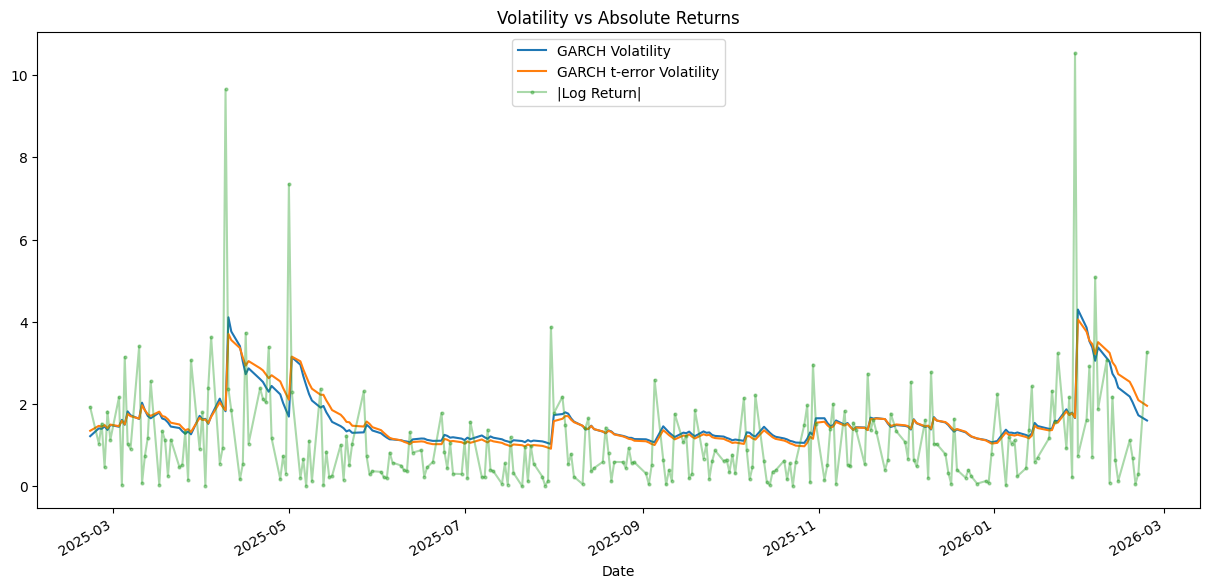

In [25]:
plt.figure(figsize=(15,7))

rolling_pred_g.iloc[-252:].plot(label="GARCH Volatility")
rolling_pred_garch_t.iloc[-252:].plot(label="GARCH t-error Volatility")
r_pct[-duration:].abs().iloc[-252:].plot(alpha=0.4, label="|Log Return|", marker='o', markersize=2)

plt.title("Volatility vs Absolute Returns")
plt.legend()
plt.show()

GARCH with Students t-error distribution is able to capture tail (spikes in vol) but take 3-5 days. Here higher speed is required.

## Regime Shift

For baseline regime shift detection, percentile-based rolling var approach is used.

Stress duration ≈ 15-25 days from GARCH vol, 21 fits normal for rolling window

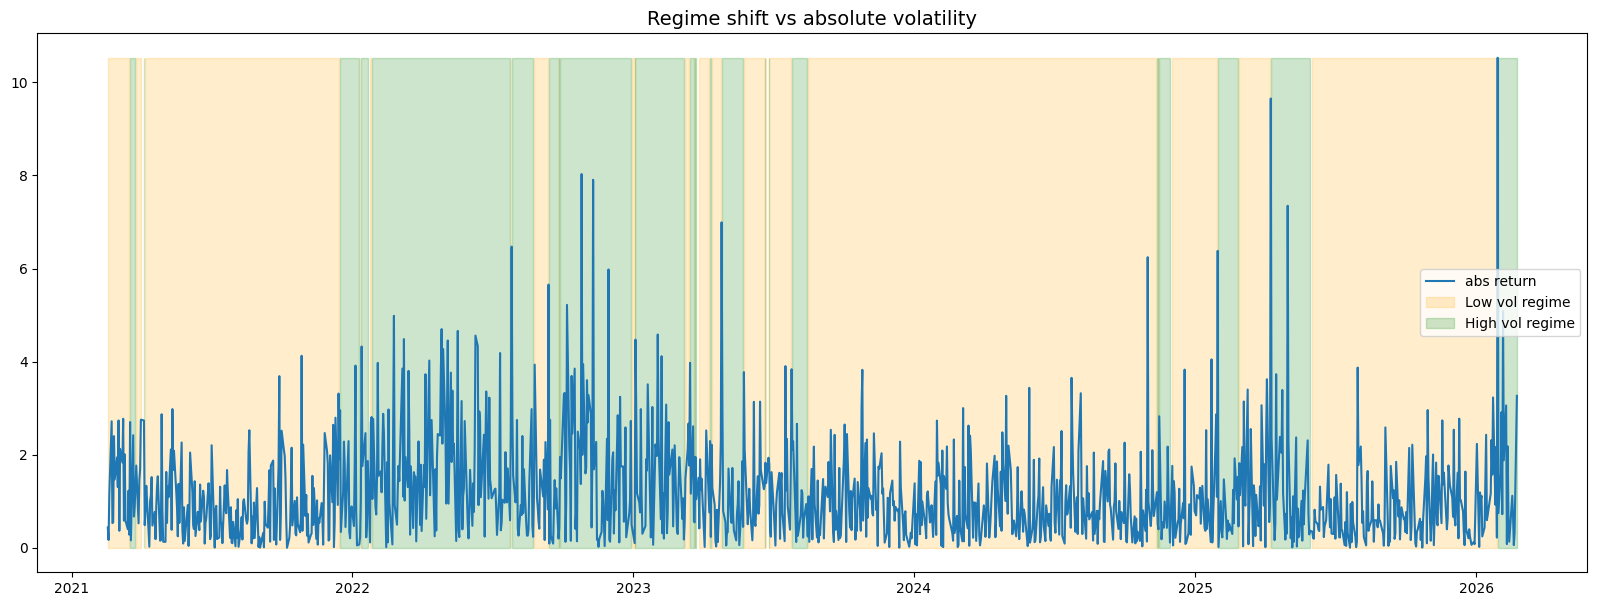

In [86]:
rolling_vol = r_pct.rolling(21).std()
threshold = rolling_vol.quantile(0.7)

window = 252 * 5
r_plot = r_pct.iloc[-window:]
vol_plot = rolling_vol.loc[r_plot.index]   # align

low_regime_mask = vol_plot < threshold
high_regime_mask = vol_plot >= threshold

fig, ax = plt.subplots(figsize=(20, 7))
y = r_plot.abs()
ax.plot(r_plot.index, y, label="abs return")

# Fill only where low regime is True
ax.fill_between(r_plot.index, 0, y.max(), where=low_regime_mask,
                color="orange", alpha=0.2, label="Low vol regime")
ax.fill_between(r_plot.index, 0, y.max(), where=high_regime_mask, 
                color="green", alpha=0.2, label='High vol regime')
plt.title('Regime shift vs absolute volatility', fontsize=14)
ax.legend()
plt.show()

To handle instant burst, 2 threshold where high for entry and low for exit will be used and will cool-off period of 15 days.

In [ ]:
# r_pct: your return series (ideally log returns or pct returns), indexed by date

roll_window = 21

rolling_vol = r_pct.rolling(roll_window).std()

# choose the same plotting window as your r_plot
window = 252 * 5
r_plot = r_pct.iloc[-window:]

vol_plot = rolling_vol.loc[r_plot.index].dropna()
r_plot = r_plot.loc[vol_plot.index]

In [ ]:
# Hysteresis thresholds - Using High threshold to enter regime, lower to exit ---
q_enter = 0.80
q_exit  = 0.60

enter_th = vol_plot.quantile(q_enter)
exit_th  = vol_plot.quantile(q_exit)

# build sticky regime state ---
state = []
in_high = False
for v in vol_plot.values:
    if (not in_high) and (v >= enter_th):
        in_high = True
    elif in_high and (v <= exit_th):
        in_high = False
    state.append(in_high)

high_raw = pd.Series(state, index=vol_plot.index)

In [123]:
min_len = 15   # minimum consecutive days to call it a regime (tune: 10–25)

m = high_raw.astype(int).copy()
grp = (m != m.shift()).cumsum()
run_len = m.groupby(grp).transform("size")

# convert short True runs (high regime) into False
high = high_raw.copy()
high[(high_raw == True) & (run_len < min_len)] = False

low = ~high

In [ ]:
k = 3.0  # shock threshold multiplier
# isolated spike treatement as shock - regime won't change
shock = (r_plot.abs() > k * vol_plot)

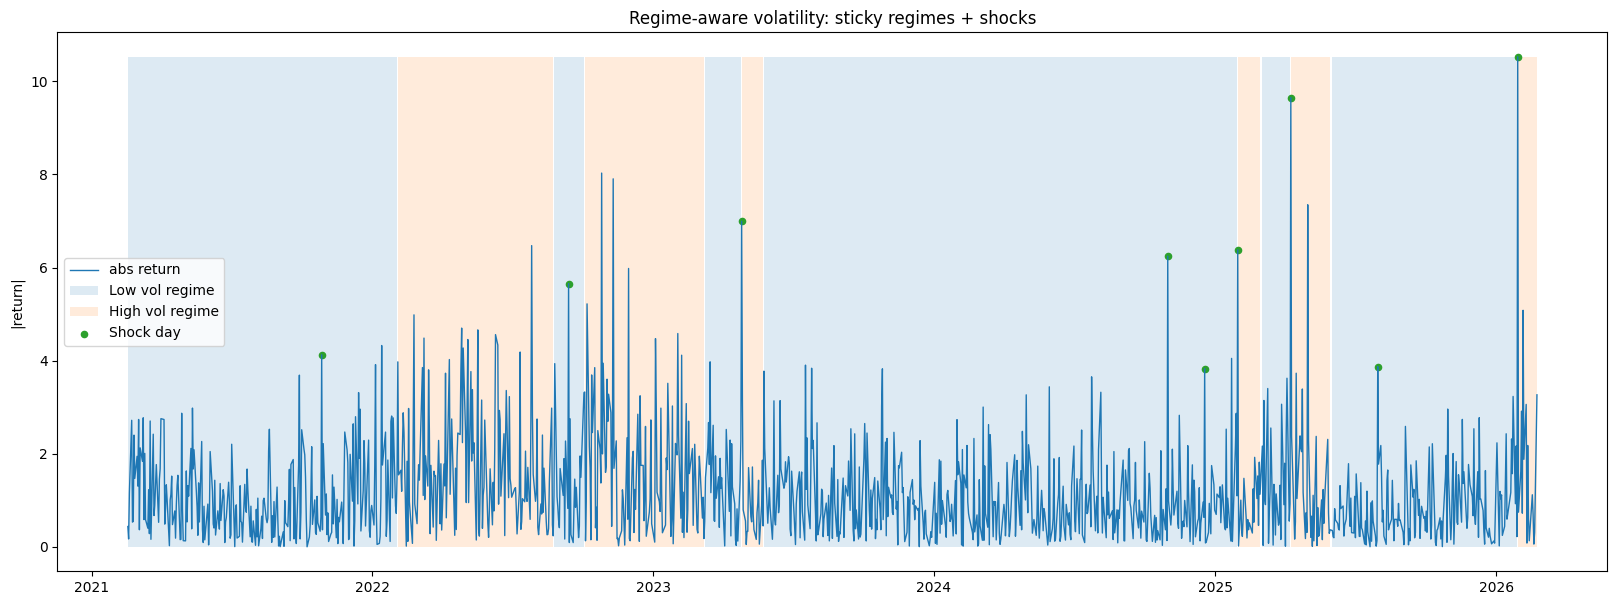

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 7))

# main series (absolute returns)
y = r_plot.abs()
ax.plot(y.index, y, linewidth=1, label="abs return")

# shade regimes (use full height so it’s easy to see)
y_top = y.max()

ax.fill_between(y.index, 0, y_top, where=low.values,
                alpha=0.15, label="Low vol regime")

ax.fill_between(y.index, 0, y_top, where=high.values,
                alpha=0.15, label="High vol regime")

# mark shock days (isolated spikes)
if "shock" in globals():
    ax.scatter(y.index[shock.values], y[shock.values],
               s=20, marker="o", label="Shock day")

ax.set_title("Regime-aware volatility: sticky regimes + shocks")
ax.set_ylabel("|return|")
ax.legend()
plt.show()

## Regime Aware Volatility (2-regime)

In [ ]:
def build_sticky_regime(returns, vol_window=21, q_enter=0.90, q_exit=0.75, min_len=20):
    """
    returns: pd.Series of returns (e.g., r_pct)
    Output:
      vol_plot: aligned rolling vol series
      high: sticky high-vol regime boolean series (same index as vol_plot/returns aligned)
      low: inverse of high
      enter_th, exit_th: thresholds used
    """
    rolling_vol = returns.rolling(vol_window).std()

    # align to non-na index
    vol_plot = rolling_vol.dropna()
    r_aligned = returns.loc[vol_plot.index]

    enter_th = vol_plot.quantile(q_enter)
    exit_th  = vol_plot.quantile(q_exit)

    # hysteresis state machine
    state = []
    in_high = False
    for v in vol_plot.values:
        if (not in_high) and (v >= enter_th):
            in_high = True
        elif in_high and (v <= exit_th):
            in_high = False
        state.append(in_high)

    high_raw = pd.Series(state, index=vol_plot.index)

    # remove short high runs (islands)
    m = high_raw.astype(int)
    grp = (m != m.shift()).cumsum()
    run_len = m.groupby(grp).transform("size")

    high = high_raw.copy()
    high[(high_raw == True) & (run_len < min_len)] = False

    low = ~high

    return r_aligned, vol_plot, high, low, enter_th, exit_th

In [128]:
def rolling_vol_regime_aware(returns, high_regime, duration, TARGET=1, 
                             mean="Zero", p=1, q=1, low_model_kwargs=None, 
                             high_model_kwargs=None):
    if low_model_kwargs is None:
        low_model_kwargs = {}
    if high_model_kwargs is None:
        high_model_kwargs = {}

    pred_vol_list = []
    idx = returns.index

    # Safety: ensure alignment
    returns = returns.loc[high_regime.index]
    high_regime = high_regime.loc[returns.index]

    # Forecast over the last `duration` points
    for step in range(duration):
        # forecast origin index position
        t_pos = len(returns) - duration + step

        train = returns.iloc[:t_pos]  # expanding window up to (but excluding) origin
        is_high = bool(high_regime.iloc[t_pos])

        if is_high:
            model = arch_model(train, mean=mean, vol="EGARCH", p=p, q=q, dist="StudentsT", **high_model_kwargs,
            )
        else:
            model = arch_model(train, mean=mean, vol="GARCH", p=p, q=q, dist="StudentsT", **low_model_kwargs,
            )

        fit = model.fit(disp="off")
        fcst = fit.forecast(horizon=TARGET)

        # take t+1 variance at forecast origin
        pred_var = fcst.variance.iloc[-1, 0]
        pred_vol = float(np.sqrt(pred_var))

        pred_vol_list.append(pred_vol)
        print(f"\rDone {step+1}/{duration}", end="")

    pred_vol = pd.Series(pred_vol_list, index=idx[-duration:])
    return pred_vol

In [132]:
# 1) Build sticky regimes
r_aligned, vol_plot, high, low, enter_th, exit_th = build_sticky_regime(r_pct, vol_window=21, q_enter=0.90, q_exit=0.75, min_len=20)

# 2) Forecast last N days with regime-aware models
duration = 2*252  
rolling_pred_regime_aware = rolling_vol_regime_aware(returns=r_aligned, high_regime=high, duration=duration, 
                                    TARGET=1, mean="Zero", p=1, q=1)

Done 504/504

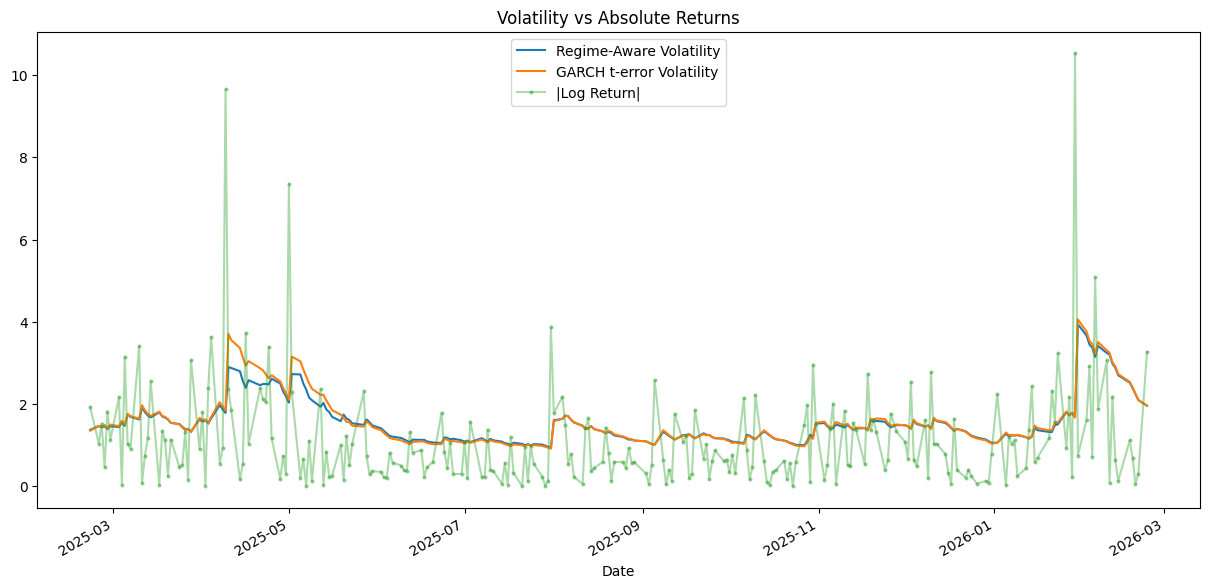

In [133]:
plt.figure(figsize=(15,7))

pred_vol.iloc[-252:].plot(label="Regime-Aware Volatility")
rolling_pred_garch_t.iloc[-252:].plot(label="GARCH t-error Volatility")
r_pct[-duration:].abs().iloc[-252:].plot(alpha=0.4, label="|Log Return|", marker='o', markersize=2)

plt.title("Volatility vs Absolute Returns")
plt.legend()
plt.show()

## Model Comparision

In [ ]:
# Build realized volatility proxy (truth)
def realized_vol_proxy(returns: pd.Series, window: int = 5, kind: str = "rv") -> pd.Series:
    """
    Returns a proxy for realized volatility on the SAME SCALE as returns.
    - kind="rv": sqrt(sum r^2) over window (vol over window)
    - kind="rms": sqrt(mean r^2) over window (avg daily vol over window)
    """
    r2 = returns.pow(2)
    if kind == "rv":
        return r2.rolling(window).sum().pow(0.5)
    elif kind == "rms":
        return r2.rolling(window).mean().pow(0.5)
    else:
        raise ValueError("kind must be 'rv' or 'rms'")

# choose one
rv_window = 5
rv = realized_vol_proxy(r_aligned, window=rv_window, kind="rms")  # daily vol proxy

# Align everything to same index
def align_series(*series):
    idx = series[0].index
    for s in series[1:]:
        idx = idx.intersection(s.index)
    out = [s.loc[idx].dropna() for s in series]
    # after dropna, re-intersect again
    idx2 = out[0].index
    for s in out[1:]:
        idx2 = idx2.intersection(s.index)
    return [s.loc[idx2] for s in out]

rv_al, reg_al, garch_al = align_series(rv, rolling_pred_garch_t, rolling_pred_regime_aware)

# Convert vol -> variance (what losses typically use)
v_true = rv_al.pow(2)
v_reg  = reg_al.pow(2)
v_garch = garch_al.pow(2)

# Metrics (QLIKE + MSE/MAE on variance + MAE on vol)
def qlike(v_true: pd.Series, v_pred: pd.Series, eps: float = 1e-12) -> float:
    """
    QLIKE loss on variance forecasts: mean(log(v_pred) + v_true/v_pred)
    Lower is better.
    """
    vt = v_true.clip(lower=eps)
    vp = v_pred.clip(lower=eps)
    return float((np.log(vp) + (vt / vp)).mean())

def mse(a: pd.Series, b: pd.Series) -> float:
    return float(((a - b) ** 2).mean())

def mae(a: pd.Series, b: pd.Series) -> float:
    return float((a - b).abs().mean())

results = {
    "QLIKE (variance) ↓": {
        "Regime-aware": qlike(v_true, v_reg),
        "GARCH-only":   qlike(v_true, v_garch),
    },
    "MSE (variance) ↓": {
        "Regime-aware": mse(v_true, v_reg),
        "GARCH-only":   mse(v_true, v_garch),
    },
    "MAE (variance) ↓": {
        "Regime-aware": mae(v_true, v_reg),
        "GARCH-only":   mae(v_true, v_garch),
    },
    "MAE (vol) ↓": {
        "Regime-aware": mae(rv_al, reg_al),
        "GARCH-only":   mae(rv_al, garch_al),
    },
}

pd.DataFrame(results)

,QLIKE (variance) ↓,MSE (variance) ↓,MAE (variance) ↓,MAE (vol) ↓
Regime-aware,1.526940,5.430363,1.232054,0.396401
GARCH-only,1.535315,6.230231,1.263998,0.404450


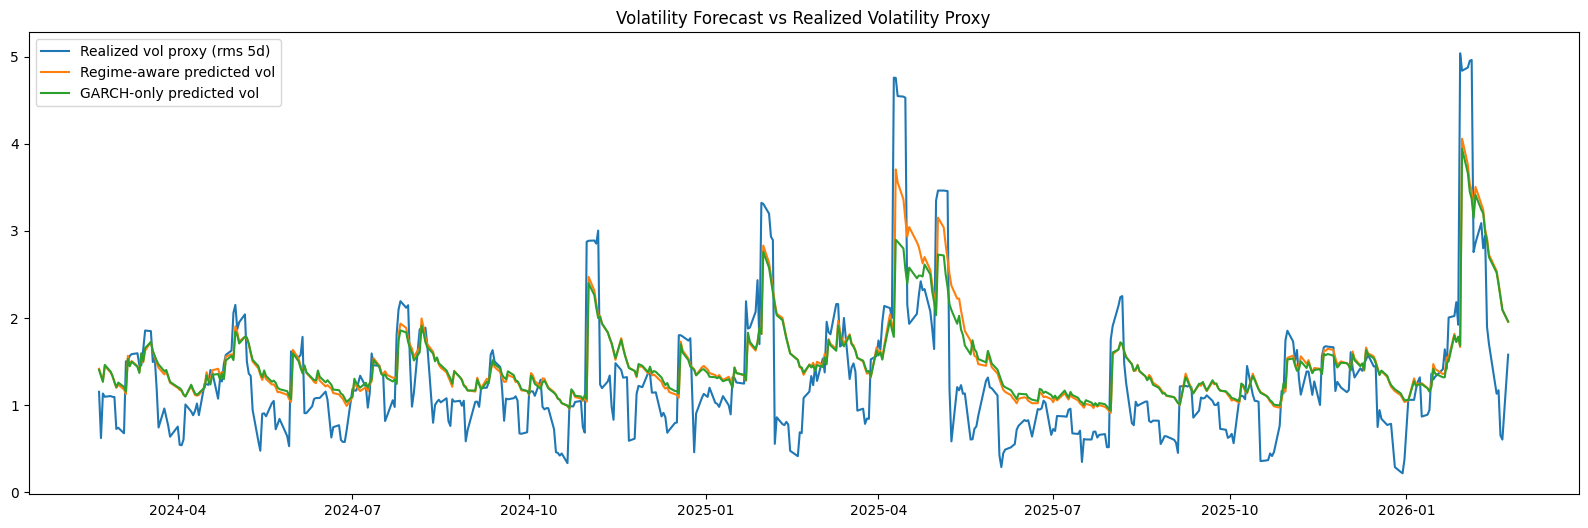

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(rv_al.index, rv_al, label=f"Realized vol proxy (rms {rv_window}d)")
ax.plot(reg_al.index, reg_al, label="Regime-aware predicted vol")
ax.plot(garch_al.index, garch_al, label="GARCH-only predicted vol")
ax.set_title("Volatility Forecast vs Realized Volatility Proxy")
ax.legend()
plt.show()

In [138]:
# Evaluate inside regimes (if you have high/low mask)
def eval_by_mask(mask: pd.Series, name: str):
    # Align mask to evaluation index
    m = mask.loc[rv_al.index].fillna(False)

    vt = v_true.loc[m.index][m]
    vr = v_reg.loc[m.index][m]
    vg = v_garch.loc[m.index][m]

    return pd.Series({
        "count": int(m.sum()),
        "QLIKE_reg": qlike(vt, vr) if len(vt) > 0 else np.nan,
        "QLIKE_garch": qlike(vt, vg) if len(vt) > 0 else np.nan,
        "MSEv_reg": mse(vt, vr) if len(vt) > 0 else np.nan,
        "MSEv_garch": mse(vt, vg) if len(vt) > 0 else np.nan,
    }, name=name)

pd.DataFrame([eval_by_mask(low, "LOW regime"), eval_by_mask(high, "HIGH regime")])

,count,QLIKE_reg,QLIKE_garch,MSEv_reg,MSEv_garch
LOW regime,476.0,1.442286,1.448376,3.636530,3.782149
HIGH regime,28.0,2.966054,3.013269,35.925529,47.847616


Overall improvements v/s single GARCH model were modest (~0.5% QLIKE), but performance gains is stronger during high-volatility periods (~25% lower variance MSE).

This suggests regime-aware modeling adds robustness particularly during risky market conditions rather than uniformly improving average accuracy.

## Next Steps:
* Perform HMM based regime detection.
* Price Chart Simulation by converting volatility into price interval. 